# Load Data For Colab usage

In [2]:
# configuration for kaggle API
!mkdir ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json"  ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

# Download data from kaggle
! kaggle competitions download -c dogs-vs-cats

# Copy local function to load data into folders
! cp "/content/drive/MyDrive/Deep Learning Class/image_loader_for_colab.py" /content/

from image_loader_for_colab import load_dogs_vs_cats, get_data_location

source_file = r'/content/dogs-vs-cats.zip'
base_dir = r'/content/dogs-vs-cats'

train_dir, validation_dir, test_dir = load_dogs_vs_cats(source_file=source_file, base_dir=base_dir)


 99% 808M/812M [00:04<00:00, 212MB/s]
100% 812M/812M [00:04<00:00, 172MB/s]
total training cat images:  1000
total validation cat images:  500
total test cat images:  500

total training dog images:  1000
total validation dog images:  500
total test dog images:  500


In [3]:
from image_loader_for_colab import load_dogs_vs_cats, get_data_location
base_dir = r'/content/dogs-vs-cats'
train_dir, validation_dir, test_dir = get_data_location(base_dir=base_dir)

---------------------
# Load Data for Local usage

In [ ]:
original_file = os.path.join('D:', os.path.sep, 'Prg', 'Class', 'Deep Learning Class','datasets', 'dogs-vs-cats.zip')
base_dir=os.path.join('D:', os.path.sep, 'Prg', 'Class', 'Deep Learning Class','datasets', 'dogs-vs-cats')

# train_dir, validation_dir, test_dir = image_loader.get_data_location(base_dir=base_dir)
train_dir, validation_dir, test_dir = image_loader.load_dogs_vs_cats(source_file=original_file, base_dir=base_dir)

## Main Program

**Note: This method takes too much time**

In [3]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
import tensorflow.keras.optimizers
# from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from keras.applications.vgg16 import VGG16

import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
os.path.expanduser('~/.keras/models/')

'/root/.keras/models/'

In [5]:
# Load convolution layers of model and ignore (dont load) FC layers
conv_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 0s 0us/step


## Create new model with pretrained model as a layer

In [6]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# predict sample data to get model parameter shape
# conv_base.predict(test_dir)

In [7]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [10]:
# Trainable prameters with conv base parmeters
conv_base.trainable=True
print('Trainable weights before freezing:', len(model.trainable_weights)//2)
model.summary()

Trainable weights before freezing: 15
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________

In [11]:
# Trainable prameters without conv base parmeters
conv_base.trainable=False
print('Trainable weights after freezing:', len(model.trainable_weights))
model.summary()

Trainable weights after freezing: 4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
________________________________________

In [12]:
batch_size=20

train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# test data must NOT be augmented.
test_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = test_data_gen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
model.compile(optimizer=RMSprop(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['acc']
             )

In [14]:
%%time
history = model.fit(x=train_generator,
                    epochs=30,
                    validation_data=validation_generator)

Epoch 1/30
100/100 [==============================] - 32s 314ms/step - loss: 0.7140 - acc: 0.5820 - val_loss: 0.5134 - val_acc: 0.7900
Epoch 2/30
100/100 [==============================] - 31s 312ms/step - loss: 0.5868 - acc: 0.6835 - val_loss: 0.4311 - val_acc: 0.8310
Epoch 3/30
100/100 [==============================] - 32s 316ms/step - loss: 0.5075 - acc: 0.7500 - val_loss: 0.3844 - val_acc: 0.8440
Epoch 4/30
100/100 [==============================] - 31s 308ms/step - loss: 0.4691 - acc: 0.7790 - val_loss: 0.3548 - val_acc: 0.8450
Epoch 5/30
100/100 [==============================] - 31s 310ms/step - loss: 0.4439 - acc: 0.7820 - val_loss: 0.3327 - val_acc: 0.8600
Epoch 6/30
100/100 [==============================] - 31s 309ms/step - loss: 0.4409 - acc: 0.7920 - val_loss: 0.3206 - val_acc: 0.8620
Epoch 7/30
100/100 [==============================] - 31s 311ms/step - loss: 0.4135 - acc: 0.8145 - val_loss: 0.3087 - val_acc: 0.8740
Epoch 8/30
100/100 [==============================] - 3

In [15]:
model.save('./models/cat_dog_transfer_vgg_16_aug.h5')
keras.models.save_model(model, './models/cat_dog_transfer_vgg_16_aug.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


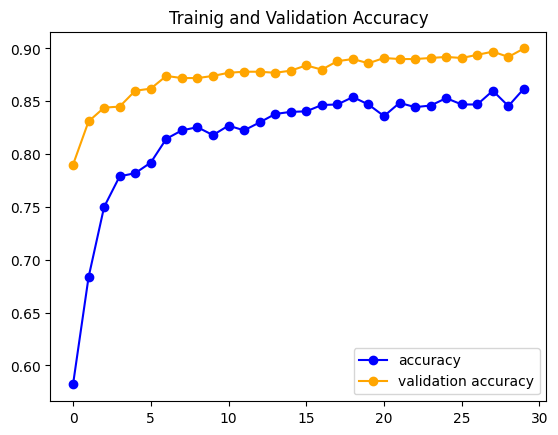

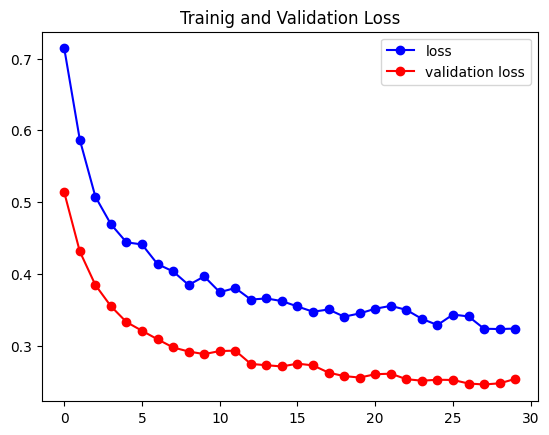

In [16]:
plt.plot(history.history['acc'], marker='o', color='blue',label='accuracy')
plt.plot(history.history['val_acc'], marker='o' ,color='orange' ,label='validation accuracy')
plt.title('Trainig and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(history.history['loss'],  marker='o', color='blue',label='loss')
plt.plot(history.history['val_loss'],  marker='o', color='red',label='validation loss')
plt.title('Trainig and Validation Loss')
plt.legend()